Hello, and welcome to my notebook. So, I've tried many things, from custom implementation to ready solutions.
Here you can find basic stitching on multiple images (video frame sequence) implementation.
If you want to review all my attempts, you can check my GitHub repository, but be careful, there are many notebooks with trash content: https://github.com/animtel/cv-22/tree/main/notebooks

I took algorithm skeleton from here: https://kornia.readthedocs.io/en/latest/_modules/kornia/contrib/image_stitching.html#ImageStitcher

What I've done:
    1. Collect three video, that on my opinion is the best candidates to stitch:
        - video_163 - hard candidate, there is the dynamic viewpoint, camera rotation, and teleportation.
        - video_177 - the medium candidate with dynamic viewpoint change, but with smooth camera movement in different directions.
        - video_179 - easy candidate, smooth movement in one direction
    2. I've tried to implement end2end stitching pipeline:
        - Detect features
        - Describe features
        - Match features
        - Robustly estimate the homography
        - Stitch mosaic
    3. I've failed in stitching with multiple camera directions, rotation, and teleportation.
    
Thank you for 

In [2]:
device = 'cuda:0'

# Read video frames:

In [3]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import torch

import matplotlib.pyplot as plt

In [4]:
ref_video_path = Path('data/ref_video.mp4')
save_frames_path = Path('data/frames')
save_frames_path.mkdir(exist_ok=True, parents=True)

In [15]:
def read_video(file, start_from=0, n_frames=None):
    capture = cv2.VideoCapture(file)
    fps = capture.get(cv2.CAP_PROP_FPS)
    k = capture.get(cv2.CAP_PROP_FRAME_COUNT)
    if n_frames is None:
        n_frames = k

    frames = []

    counter = 0
    for i in tqdm(np.arange(k)):
        if counter == n_frames:
            break
        success, image_cv = capture.read()
        
        if not success:
            break
            
        if i < start_from:
            continue

        frame = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        frame = torch.tensor(frame/255, dtype=torch.float32)
        frame = frame.permute(2,0,1)[None]
        frame = torch.transpose(frame, 2, 3)
        frames.append(frame)
        counter += 1

    return frames, fps, n_frames

In [38]:
frames, fps, n_frames = read_video(str(ref_video_path), start_from=0, n_frames=500)

 20%|███████████████▉                                                               | 500/2487 [00:04<00:17, 116.28it/s]


# Preprocess data

In [39]:
import torchvision.transforms as T

In [40]:
def torch_resize(img, scale_factor):
    width = int(img.shape[3] * scale_factor)
    height = int(img.shape[2] * scale_factor)
    dim = (height, width)
    
    resize_f = T.Resize(dim)

    # resize image
    resized = resize_f(img)
    return resized

In [41]:
scale_factor = 0.5

In [42]:
timgs = []
frames2stitch_freq = 15
for i, frame in enumerate(frames):
    if i % frames2stitch_freq == 0:
        timgs.append(torch_resize(frame, scale_factor).to(device))

In [43]:
len(timgs), timgs[0].shape

(34, torch.Size([1, 3, 640, 360]))

# Stitch by kornia stitcher

In [44]:
# from kornia.contrib import ImageStitcher
# import kornia.feature as KF
# import kornia as K

# IS = ImageStitcher(KF.LoFTR(pretrained='outdoor'), estimator='ransac').to(device)

In [45]:
# out = timgs[0]
# idxs = list(range(1, len(timgs)))
# for i in tqdm(idxs):
#     try:
#         prev_out = out
#         out = IS(*[out, timgs[i]])
#     except Exception as e:
#         print(e)
#         out = prev_out

In [46]:
# import matplotlib.pyplot as plt

In [47]:
# plt.figure(figsize=(16,16))
# plt.imshow(out[0].permute(1, 2, 0).cpu())

# Custom stitching

In [48]:
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn

import kornia.feature
from kornia.color import rgb_to_grayscale
from kornia.feature import LocalFeatureMatcher, LoFTR, BlobDoG, ScaleSpaceDetector
from kornia.geometry.homography import find_homography_dlt_iterated
from kornia.geometry.ransac import RANSAC
from kornia.geometry.transform import warp_perspective

import kornia.feature as KF
import matplotlib.pyplot as plt

In [49]:
#Now lets try with Difference-of-Gaussians + OriNet + TFeat
class CustMatcher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.PS = 41

        sift = kornia.feature.TFeat(True).to(device)
        sift = kornia.feature.SIFTDescriptor(self.PS, rootsift=True).to(device)

        self.descriptor = sift

        resp = BlobDoG()
        scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, self.PS, double_image=True)

        nms = kornia.geometry.ConvQuadInterp3d(10)

        n_features = 4000
        self.detector = ScaleSpaceDetector(n_features,
                                      resp_module=resp,
                                      scale_space_response=True,#We need that, because DoG operates on scale-space
                                      nms_module=nms,
                                      scale_pyr_module=scale_pyr,
                                      ori_module=kornia.feature.LAFOrienter(32, 
                                                                            angle_detector=kornia.feature.OriNet(True)),
                                      mr_size=6.0,
                                      minima_are_also_good=True).to(device) #dark blobs are as good as bright.

    def get_descriptors(self, img):
        """
        img shape: B, C, H, W
        """
        with torch.no_grad():
            lafs, resps = self.detector(img)
            patches =  kornia.feature.extract_patches_from_pyramid(img, lafs, self.PS)
            B, N, CH, H, W = patches.size()
            # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
            # So we need to reshape a bit :) 
            descs = self.descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs
        
    def forward(self, image_pair):
        """
        image_pair: dict = {
            "image0": img,
            "image1": img
        }
        """
        with torch.no_grad():
            lafs_src, descs_src = self.get_descriptors(image_pair['image0'])
            lafs_dst, descs_dst = self.get_descriptors(image_pair['image1'])
            scores, matches = kornia.feature.match_snn(descs_src[0], descs_dst[0], 0.9)

        src_pts = lafs_src[0,matches[:,0], :, 2]
        dst_pts = lafs_dst[0,matches[:,1], :, 2]
        
        return (src_pts, dst_pts, matches)

In [50]:
matcher = CustMatcher().to(device)
estimator = 'ransac'
blending_method = 'naive'
ransac = RANSAC('homography').to(device)

In [51]:
def estimate_homography(keypoints1: torch.Tensor, keypoints2: torch.Tensor) -> torch.Tensor:
    """Estimate homography by the matched keypoints.

    Args:
        keypoints1: matched keypoint set from an image, shaped as :math:`(N, 2)`.
        keypoints2: matched keypoint set from the other image, shaped as :math:`(N, 2)`.
    """
    homo, _ = ransac(keypoints2, keypoints1)
    homo = homo[None]
    return homo

def estimate_transform(src_pts, dst_pts, matches) -> torch.Tensor:
    """Compute the corresponding homography."""
    homos: List[torch.Tensor] = []
    kp1, kp2, idx = src_pts, dst_pts, matches
    homos.append(estimate_homography(kp1, kp2))
    if len(homos) == 0:
        raise RuntimeError("Compute homography failed. No matched keypoints found.")
    return torch.cat(homos)

def blend_image(src_img: torch.Tensor, dst_img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Blend two images together."""
    out: torch.Tensor
    out = torch.where(mask == 1, src_img, dst_img)
    return out

def preprocess(image_1: torch.Tensor, image_2: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Preprocess input to the required format."""
    input_dict: Dict[str, torch.Tensor] = {
            "image0": rgb_to_grayscale(image_1),
            "image1": rgb_to_grayscale(image_2),
        }
    return input_dict

def postprocess(image: torch.Tensor, mask: torch.Tensor, is_move_up = False) -> torch.Tensor:
    # NOTE: assumes no batch mode. This method keeps all valid regions after stitching.
    mask_: torch.Tensor = mask.sum((0, 1))
    index: int = int(mask_.bool().any(0).long().argmin().item())
    print(index)
    if index == 0:  # If no redundant space
        return image
    if is_move_up:#[1, 3, 2880, 640]
        return image[:, :, :index, :]
    else:
        return image[..., :index]

def stitch_pair(
    images_left: torch.Tensor,
    images_right: torch.Tensor,
    mask_left: Optional[torch.Tensor] = None,
    mask_right: Optional[torch.Tensor] = None,
    is_move_up = False
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Compute the transformed images
    input_dict: Dict[str, torch.Tensor] = preprocess(images_left, images_right)
    if is_move_up:
        out_shape: Tuple[int, int] = (images_left.shape[-2] + images_right.shape[-2], images_left.shape[-1])
    else:
        out_shape: Tuple[int, int] = (images_left.shape[-2], images_left.shape[-1] + images_right.shape[-1])
    src_pts, dst_pts, matches = matcher(input_dict)
    homo: torch.Tensor = estimate_transform(src_pts, dst_pts, matches)
    src_img = warp_perspective(images_right, homo, out_shape)
    
    if is_move_up:
        dst_img = torch.cat([images_left, torch.zeros_like(images_right)], dim=-2)
    else:
        dst_img = torch.cat([images_left, torch.zeros_like(images_right)], dim=-1)

    # Compute the transformed masks
    if mask_left is None:
        mask_left = torch.ones_like(images_left)
    if mask_right is None:
        mask_right = torch.ones_like(images_right)
    # 'nearest' to ensure no floating points in the mask
    src_mask = warp_perspective(mask_right, homo, out_shape, mode='nearest')
    if is_move_up:
        dst_mask = torch.cat([mask_left, torch.zeros_like(mask_right)], dim=-2)
    else:
        dst_mask = torch.cat([mask_left, torch.zeros_like(mask_right)], dim=-1)
    print("out_shape.shape", out_shape)
    print("dst_mask.shape", dst_mask.shape)
    print("src_mask.shape", src_mask.shape)
    print("src_img.shape", src_img.shape)
    print("dst_img.shape", dst_img.shape)
    blended_img = blend_image(src_img, dst_img, src_mask)
    blended_mask = (dst_mask + src_mask).bool().to(src_mask.dtype)
    return blended_img, blended_mask

In [52]:
mask_left.shape

torch.Size([1, 3, 640, 2419])

In [53]:
with torch.inference_mode():
    img_out = timgs[0]
    mask_left = torch.ones_like(img_out).to(device)
    for i in tqdm(list(range(len(timgs) - 1))):
        mask_left = torch.ones_like(img_out).to(device)
        img_out, mask_left = stitch_pair(img_out, timgs[i + 1], mask_left, is_move_up=False)
        img_out = postprocess(img_out, mask_left, is_move_up=False)    

  3%|██▌                                                                                 | 1/33 [00:00<00:31,  1.02it/s]

out_shape.shape (640, 720)
dst_mask.shape torch.Size([1, 3, 640, 720])
src_mask.shape torch.Size([1, 3, 640, 720])
src_img.shape torch.Size([1, 3, 640, 720])
dst_img.shape torch.Size([1, 3, 640, 720])
360


  6%|█████                                                                               | 2/33 [00:01<00:24,  1.24it/s]

out_shape.shape (640, 720)
dst_mask.shape torch.Size([1, 3, 640, 720])
src_mask.shape torch.Size([1, 3, 640, 720])
src_img.shape torch.Size([1, 3, 640, 720])
dst_img.shape torch.Size([1, 3, 640, 720])
360


  9%|███████▋                                                                            | 3/33 [00:02<00:22,  1.35it/s]

out_shape.shape (640, 720)
dst_mask.shape torch.Size([1, 3, 640, 720])
src_mask.shape torch.Size([1, 3, 640, 720])
src_img.shape torch.Size([1, 3, 640, 720])
dst_img.shape torch.Size([1, 3, 640, 720])
360


 12%|██████████▏                                                                         | 4/33 [00:03<00:20,  1.40it/s]

out_shape.shape (640, 720)
dst_mask.shape torch.Size([1, 3, 640, 720])
src_mask.shape torch.Size([1, 3, 640, 720])
src_img.shape torch.Size([1, 3, 640, 720])
dst_img.shape torch.Size([1, 3, 640, 720])
364


 15%|████████████▋                                                                       | 5/33 [00:03<00:20,  1.39it/s]

out_shape.shape (640, 724)
dst_mask.shape torch.Size([1, 3, 640, 724])
src_mask.shape torch.Size([1, 3, 640, 724])
src_img.shape torch.Size([1, 3, 640, 724])
dst_img.shape torch.Size([1, 3, 640, 724])
404


 18%|███████████████▎                                                                    | 6/33 [00:04<00:19,  1.39it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 21%|█████████████████▊                                                                  | 7/33 [00:05<00:18,  1.43it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 24%|████████████████████▎                                                               | 8/33 [00:05<00:17,  1.41it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 27%|██████████████████████▉                                                             | 9/33 [00:06<00:16,  1.42it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 30%|█████████████████████████▏                                                         | 10/33 [00:07<00:16,  1.43it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 33%|███████████████████████████▋                                                       | 11/33 [00:07<00:15,  1.42it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 36%|██████████████████████████████▏                                                    | 12/33 [00:08<00:14,  1.44it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 39%|████████████████████████████████▋                                                  | 13/33 [00:09<00:14,  1.42it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 42%|███████████████████████████████████▏                                               | 14/33 [00:10<00:13,  1.43it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 45%|█████████████████████████████████████▋                                             | 15/33 [00:10<00:12,  1.42it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 48%|████████████████████████████████████████▏                                          | 16/33 [00:11<00:12,  1.38it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 52%|██████████████████████████████████████████▊                                        | 17/33 [00:12<00:11,  1.41it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 55%|█████████████████████████████████████████████▎                                     | 18/33 [00:13<00:11,  1.32it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 58%|███████████████████████████████████████████████▊                                   | 19/33 [00:13<00:11,  1.26it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 61%|██████████████████████████████████████████████████▎                                | 20/33 [00:14<00:10,  1.29it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 64%|████████████████████████████████████████████████████▊                              | 21/33 [00:15<00:09,  1.30it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 67%|███████████████████████████████████████████████████████▎                           | 22/33 [00:16<00:08,  1.31it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 70%|█████████████████████████████████████████████████████████▊                         | 23/33 [00:16<00:07,  1.32it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 73%|████████████████████████████████████████████████████████████▎                      | 24/33 [00:17<00:06,  1.34it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 76%|██████████████████████████████████████████████████████████████▉                    | 25/33 [00:18<00:05,  1.36it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 79%|█████████████████████████████████████████████████████████████████▍                 | 26/33 [00:19<00:04,  1.40it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 82%|███████████████████████████████████████████████████████████████████▉               | 27/33 [00:19<00:04,  1.38it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 85%|██████████████████████████████████████████████████████████████████████▍            | 28/33 [00:20<00:03,  1.37it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 88%|████████████████████████████████████████████████████████████████████████▉          | 29/33 [00:21<00:02,  1.39it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 91%|███████████████████████████████████████████████████████████████████████████▍       | 30/33 [00:21<00:02,  1.37it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 94%|█████████████████████████████████████████████████████████████████████████████▉     | 31/33 [00:22<00:01,  1.34it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


 97%|████████████████████████████████████████████████████████████████████████████████▍  | 32/33 [00:23<00:00,  1.34it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]

out_shape.shape (640, 764)
dst_mask.shape torch.Size([1, 3, 640, 764])
src_mask.shape torch.Size([1, 3, 640, 764])
src_img.shape torch.Size([1, 3, 640, 764])
dst_img.shape torch.Size([1, 3, 640, 764])
404


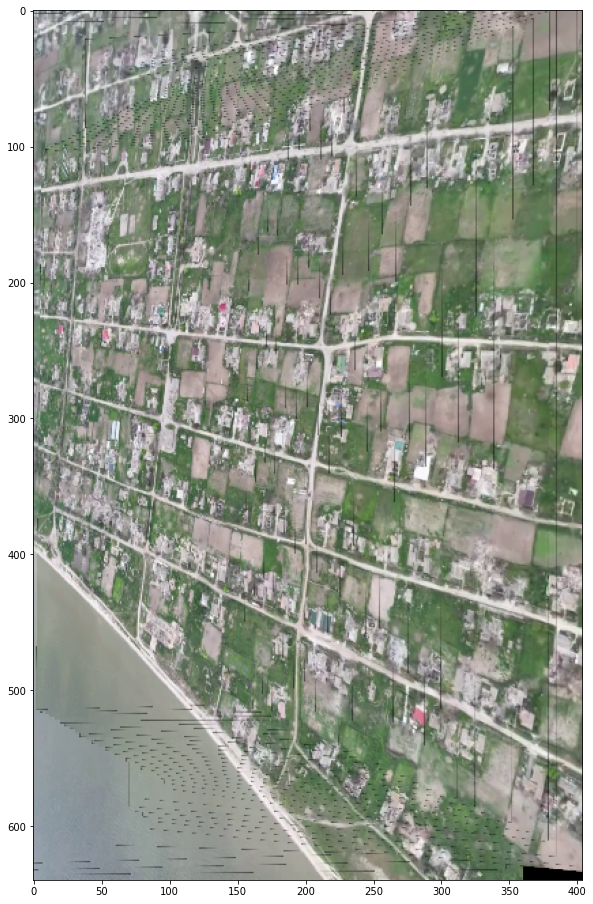

In [54]:
plt.figure(figsize=(16,16))
plt.imshow(img_out[0].permute(1, 2, 0).cpu())